# Interactive Usage of 3rd Party Libraries: [Fastjet](http://fastjet.fr) Example
<hr style="border-top-width: 4px; border-top-color: #34609b;">
This notebook illustrates how to interactively use 3rd party libraries. The example is built around [Fastjet](http://fastjet.fr), a software package for jet finding which is widely adopted in High Energy Physics. Nevertheless, the concepts discussed are valid for any C++ library.
## Some Context
Jets are the experimental signatures of quarks and gluons produced in high-energy processes such as head-on proton-proton collisions. As quarks and gluons have a net colour charge and cannot exist freely due to colour-confinement, they are not directly observed in Nature. Instead, they come together to form colour-neutral hadrons, a process called hadronisation that leads to a collimated spray of hadrons called a jet (from http://cms.web.cern.ch/news/jets-cms-and-determination-their-energy-scale).
The kinematic properties of originating quarks and gluons can be inferred by the ones of the jets. In this example we will build jets starting from an event which is an emulation of a collision of protons at the [LHC](http://home.cern/topics/large-hadron-collider).
## Preparation of the environment
ROOT needs to be told where to find
1. The interfaces of the C++ entites present in the 3rd party libraries
2. The implementations of such entities
It is therefore necessary to update the include path and load the fastjet library.

In [1]:
gInterpreter->AddIncludePath("../../../testFastjet/fastjet-install/include");
gSystem->Load("../../../testFastjet/fastjet-install/lib/libfastjet");

## Preparation of the Input Particles
Here we convert an ASCII file in ROOT format to then fill the particles necessary to Fastjet.
Notice the inclusion of the header file. Given that we instructed ROOT about its location and the Fastjet library has been loaded, the function can be smoothly JIT-ted.

In [2]:
%%cpp -d
#include "fastjet/ClusterSequence.hh"
void fillInputParticles(vector<fastjet::PseudoJet>& input_particles, const char* inputFileName) 
{
  auto ntupleFormat = "px:py:pz:E";
  TNtuple input_particles_ntuple("InputParticles","Input Particles",ntupleFormat);
  auto n_particles = input_particles_ntuple.ReadFile(inputFileName,ntupleFormat);
  input_particles.reserve(n_particles);

  for (auto i : ROOT::TSeqI(n_particles)) {
     input_particles_ntuple.GetEntry(i);
     auto v = input_particles_ntuple.GetArgs();
     fastjet::PseudoJet particle(v[0],v[1],v[2],v[3]);
     particle.set_user_index(i);
     input_particles.emplace_back(particle); 
  }
}

## Preparation of the Histogram Displaying the Jets' Components
We now need to:
1. Cluster the jets with fastjet
2. Extract the clustered particles from the jet and display them as 2D histograms
This function is flexible: the jet algorithm, its radius and the jets' minimum transverse momentum can be set by the user. This is useful to visualise the behaviour of the different algorithms.

In [3]:
%%cpp -d
THStack* getJetsComponents(const vector<fastjet::PseudoJet>& input_particles,
                          fastjet::JetAlgorithm jetAlgorithm = fastjet::antikt_algorithm, 
                          double R = .6,
                          double ptMin = 14.)
{
   // create a jet definition: 
   // a jet algorithm with a given radius parameter
   fastjet::JetDefinition jet_def(jetAlgorithm, R);
   fastjet::ClusterSequence clust_seq(input_particles, jet_def);

   // get the resulting jets ordered in pt
   auto inclusive_jets = sorted_by_pt(clust_seq.inclusive_jets(ptMin));
 
   auto hs = new THStack("hs","Jets;rapidity;#phi");
   int i=0;
   for (auto&& jet : inclusive_jets) {
     // get the constituents of the jet
     auto constituents = jet.constituents();
     auto h2Name = TString::Format("JetHist_%d",i);
     if (auto oldH2 = (TH2F*) gDirectory->GetObjectChecked(h2Name,"TH2F")) {
        delete oldH2;
   }
   auto h2 = new TH2F(h2Name,"JetHist",48, -5, 5, 48, 0, TMath::TwoPi());
   h2->SetFillColor(i+1);
   h2->SetLineWidth(1);
   h2->SetLineColor(kBlack);
   for (auto&& constituent : constituents){
      h2->Fill(constituent.rap(), constituent.phi_02pi(), constituent.perp());
   }
   hs->Add(h2);
   i++;
  }
  hs->Draw();// This creates the axes
  hs->GetXaxis()->SetTitleOffset(1.7);
  hs->GetYaxis()->SetTitleOffset(1.7);
  return hs;
}

## Clustering and Visualisation
We now prepare all the elements needed to build our plot: a canvas to hold the graphics primitives, the containers and the stack of histograms containing the jets' components.

In [4]:
TCanvas c;
c.SetTheta(90);
c.SetPhi(37);
unique_ptr<THStack> jetComponents(nullptr);

vector<fastjet::PseudoJet> input_particles;
fillInputParticles(input_particles, "../data/Pythia-Z2jets-lhc-pileup-1ev.dat");

We are ready to go now: we can play with the parameters of the clustering and visualise the result. Each jet is visualised with a different colour in the Rapidity-Phi plane.

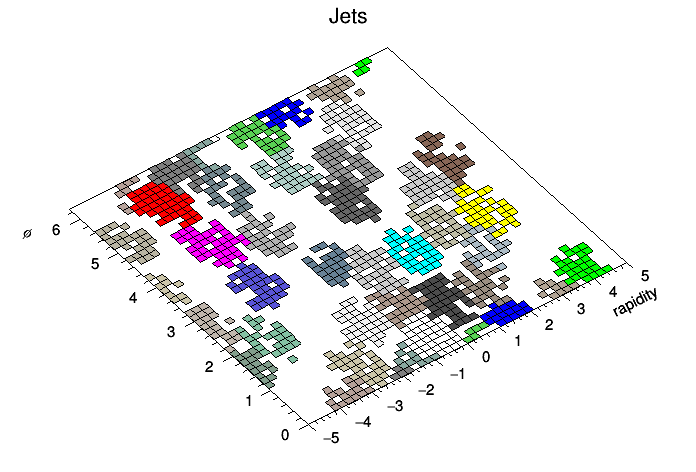

In [6]:
jetComponents.reset(getJetsComponents(input_particles, fastjet::antikt_algorithm, .6, 14.));
jetComponents->Draw("LEGO1 0");
c.Draw();